In [152]:
import timesfm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import numpy as np
import seaborn as sns
warnings.filterwarnings('ignore')

In [178]:
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="cpu",
          per_core_batch_size=32,
          horizon_len=128,
          num_layers=50,
          model_dims= 1280,
          context_len=2048,

      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

Fetching 5 files: 100%|██████████| 5/5 [00:00<?, ?it/s]


In [179]:
df = pd.read_csv('data/INTC_1H.csv')
price_columns = ['Open', 'High', 'Low', 'Close']
df[price_columns] = df[price_columns].round(2)
print(len(df))
df.head()

3488


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-03-27 14:30:00-04:00,29.52,29.60,29.39,29.42,0,0.0,0.0
1,2023-03-27 15:30:00-04:00,29.41,29.42,29.15,29.21,6123103,0.0,0.0
2,2023-03-28 09:30:00-04:00,29.08,29.14,28.75,28.80,6001110,0.0,0.0
3,2023-03-28 10:30:00-04:00,28.80,29.19,28.63,29.11,5362455,0.0,0.0
4,2023-03-28 11:30:00-04:00,29.11,29.23,28.96,28.99,3354148,0.0,0.0


In [180]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.head()

In [181]:
input_df = df
input_df = pd.DataFrame({'unique_id':[1]*len(input_df),'ds': input_df["Datetime"], "y":input_df['Close']})

In [194]:
input_df['ds'] = input_df['ds'].values.astype('datetime64[ns]')
first_n_rows = input_df.iloc[:2048]
first_n_rows

,unique_id,ds,y
0,1,2023-03-27 18:30:00,29.42
1,1,2023-03-27 19:30:00,29.21
2,1,2023-03-28 13:30:00,28.80
3,1,2023-03-28 14:30:00,29.11
4,1,2023-03-28 15:30:00,28.99
...,...,...,...
2043,1,2024-05-24 18:30:00,30.62
2044,1,2024-05-24 19:30:00,30.71
2045,1,2024-05-28 13:30:00,31.10
2046,1,2024-05-28 14:30:00,31.25


In [208]:
input_df

,unique_id,ds,y
0,1,2023-03-27 18:30:00,29.42
1,1,2023-03-27 19:30:00,29.21
2,1,2023-03-28 13:30:00,28.80
3,1,2023-03-28 14:30:00,29.11
4,1,2023-03-28 15:30:00,28.99
...,...,...,...
3483,1,2025-03-26 14:30:00,23.33
3484,1,2025-03-26 15:30:00,23.44
3485,1,2025-03-26 16:30:00,23.41
3486,1,2025-03-26 17:30:00,23.34


Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


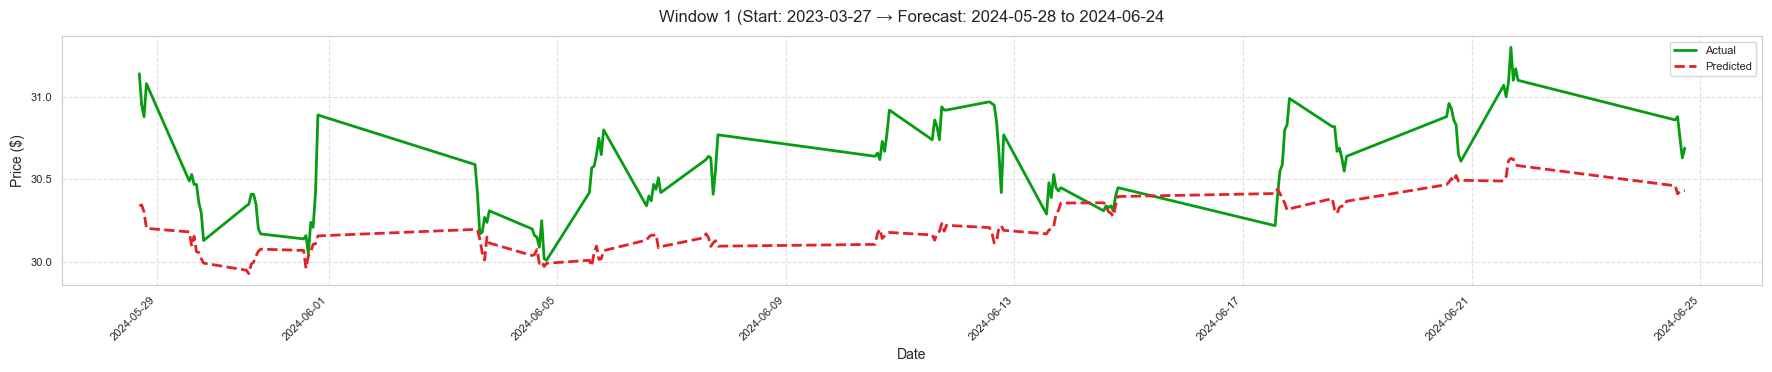

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


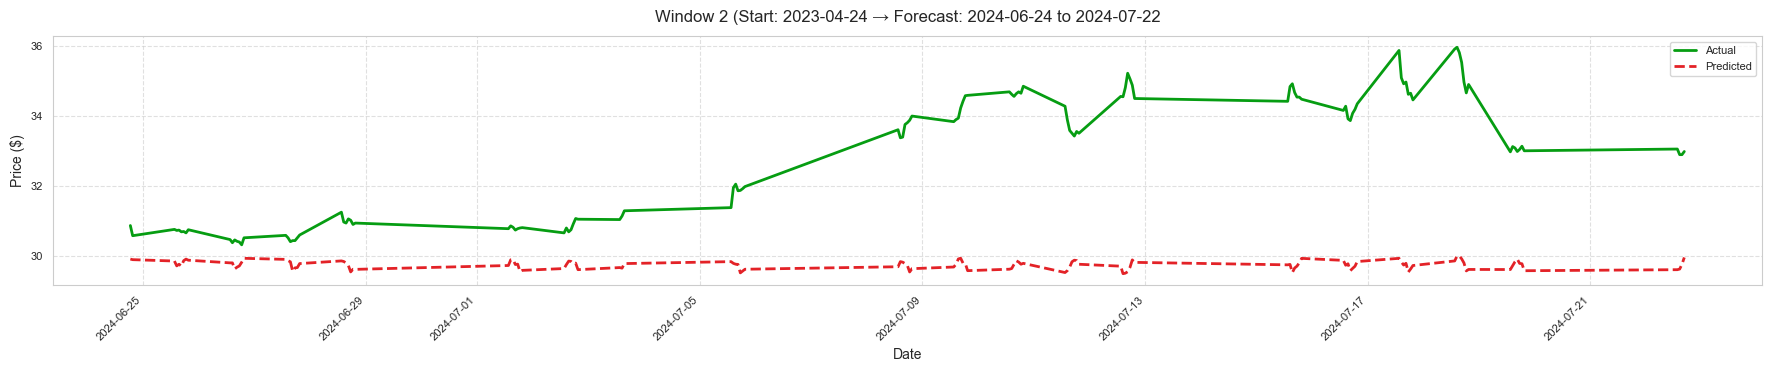

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


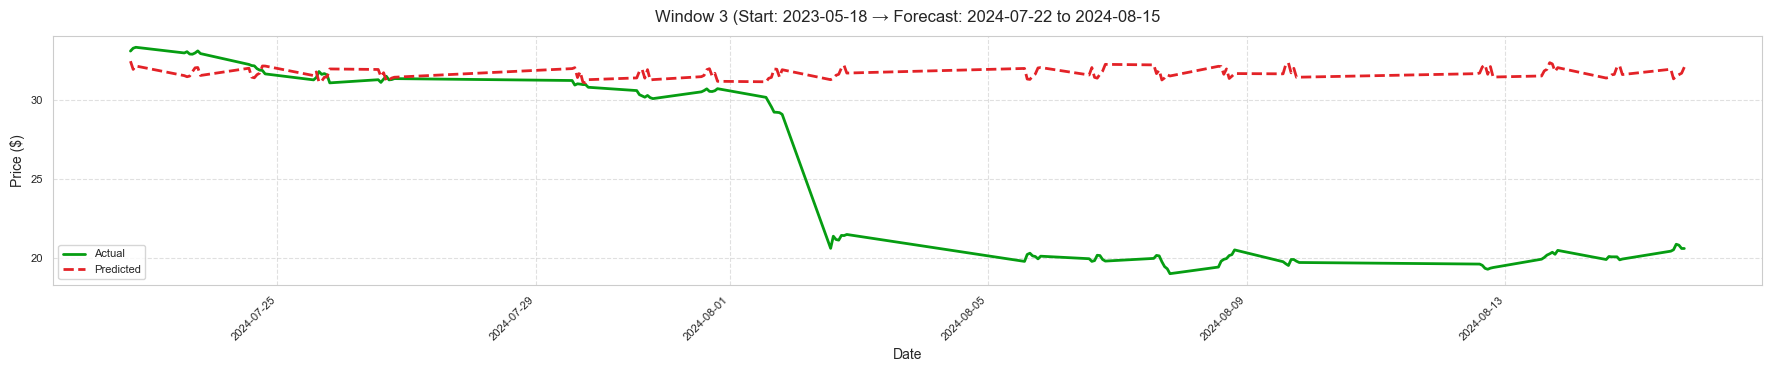

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


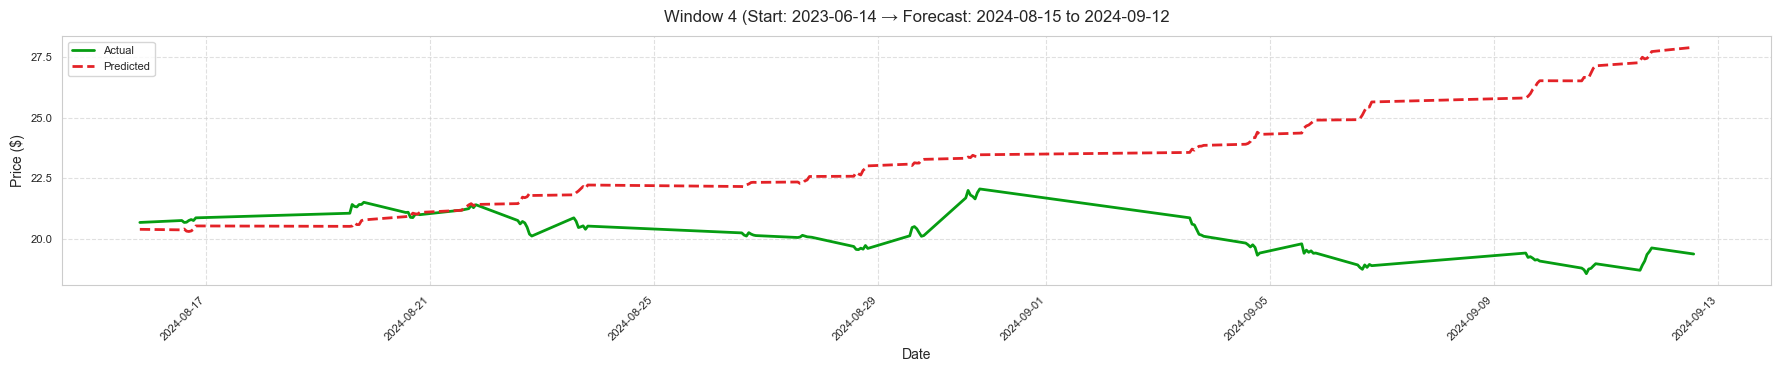

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


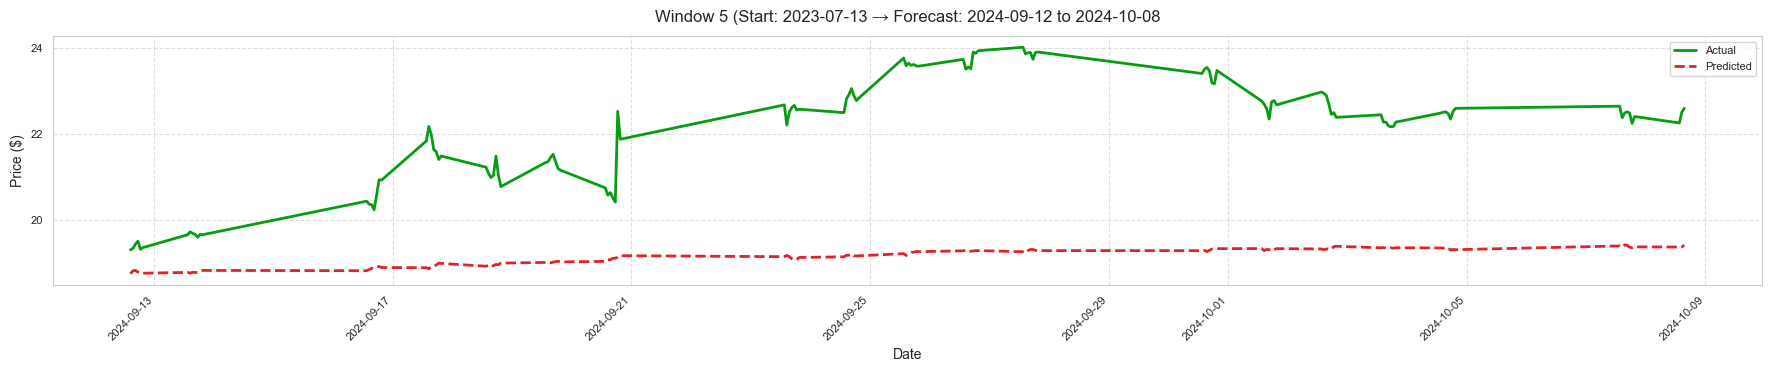

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


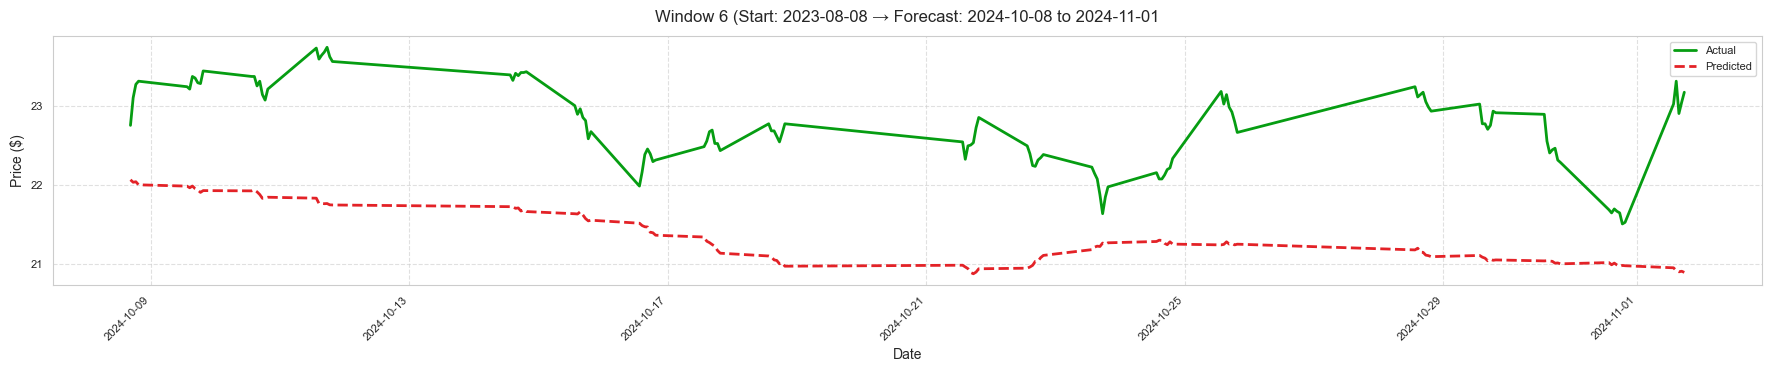

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


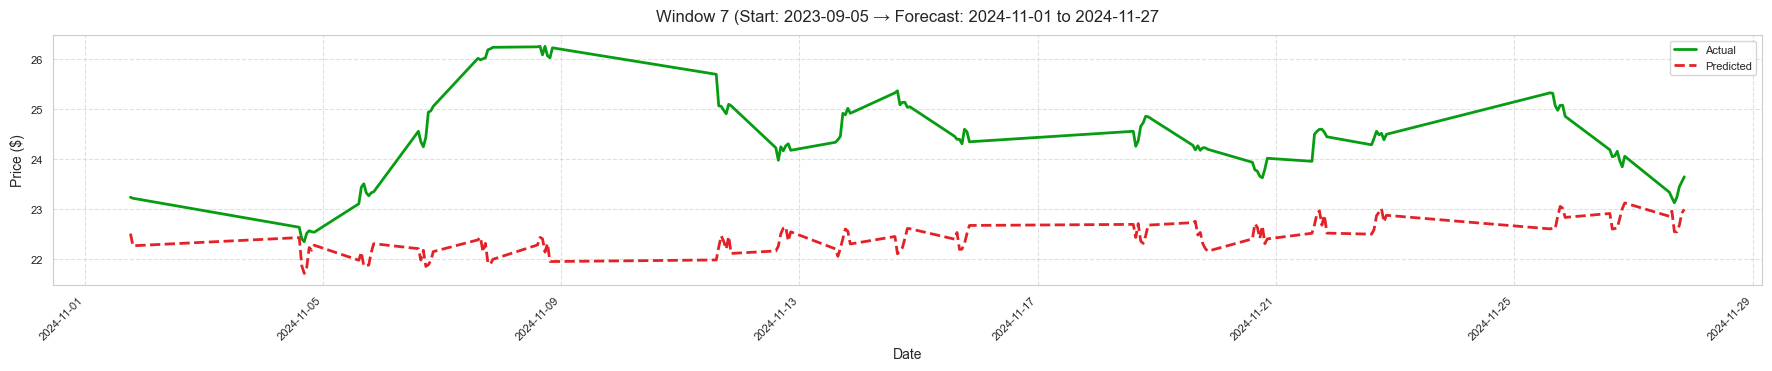

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


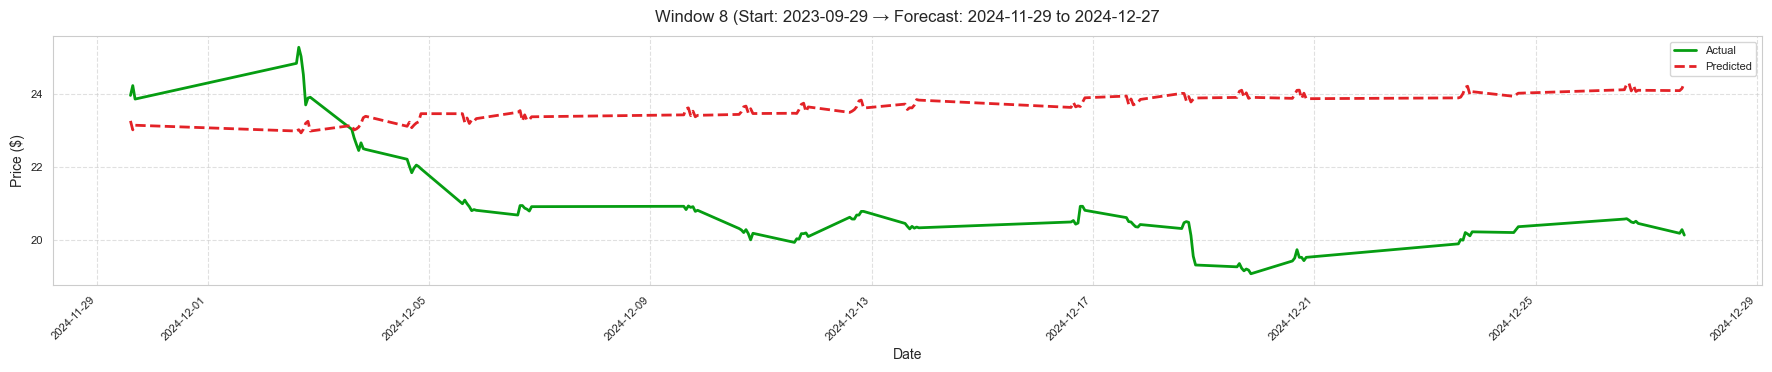

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


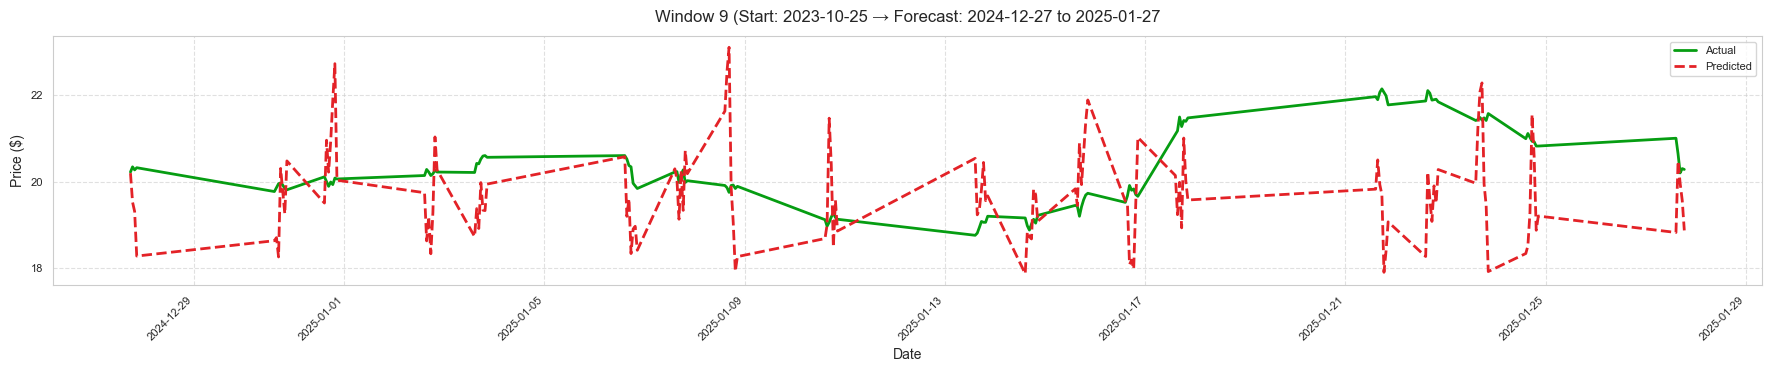

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


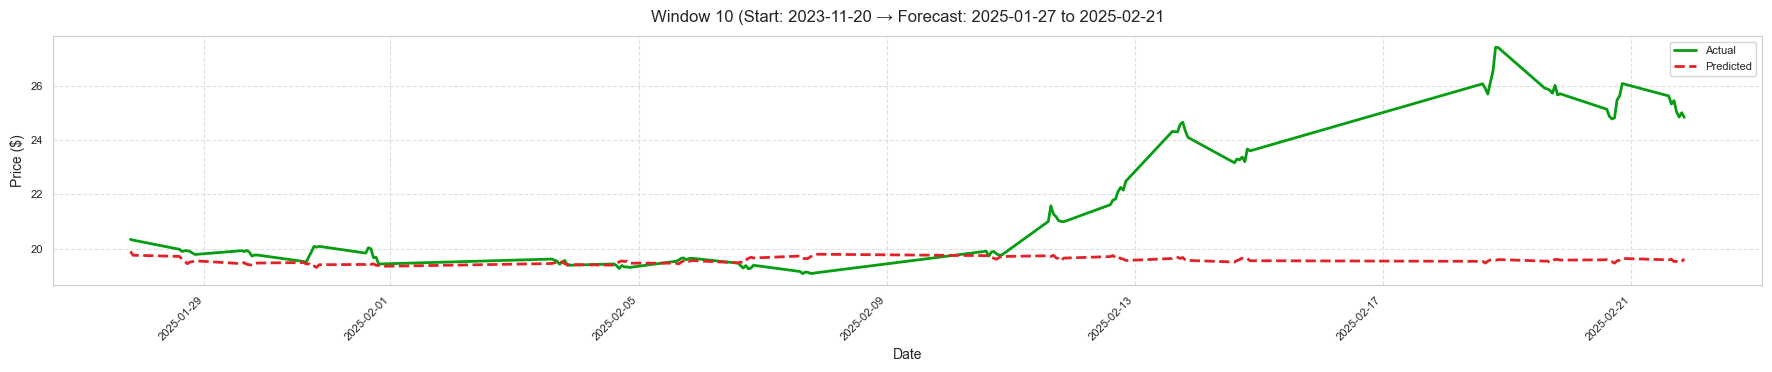

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


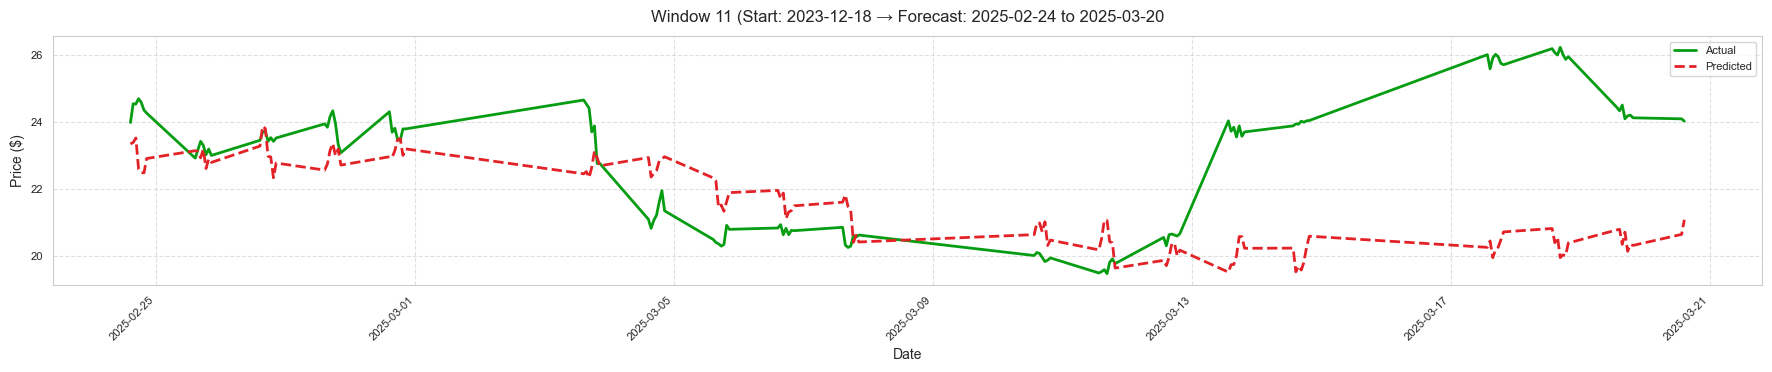

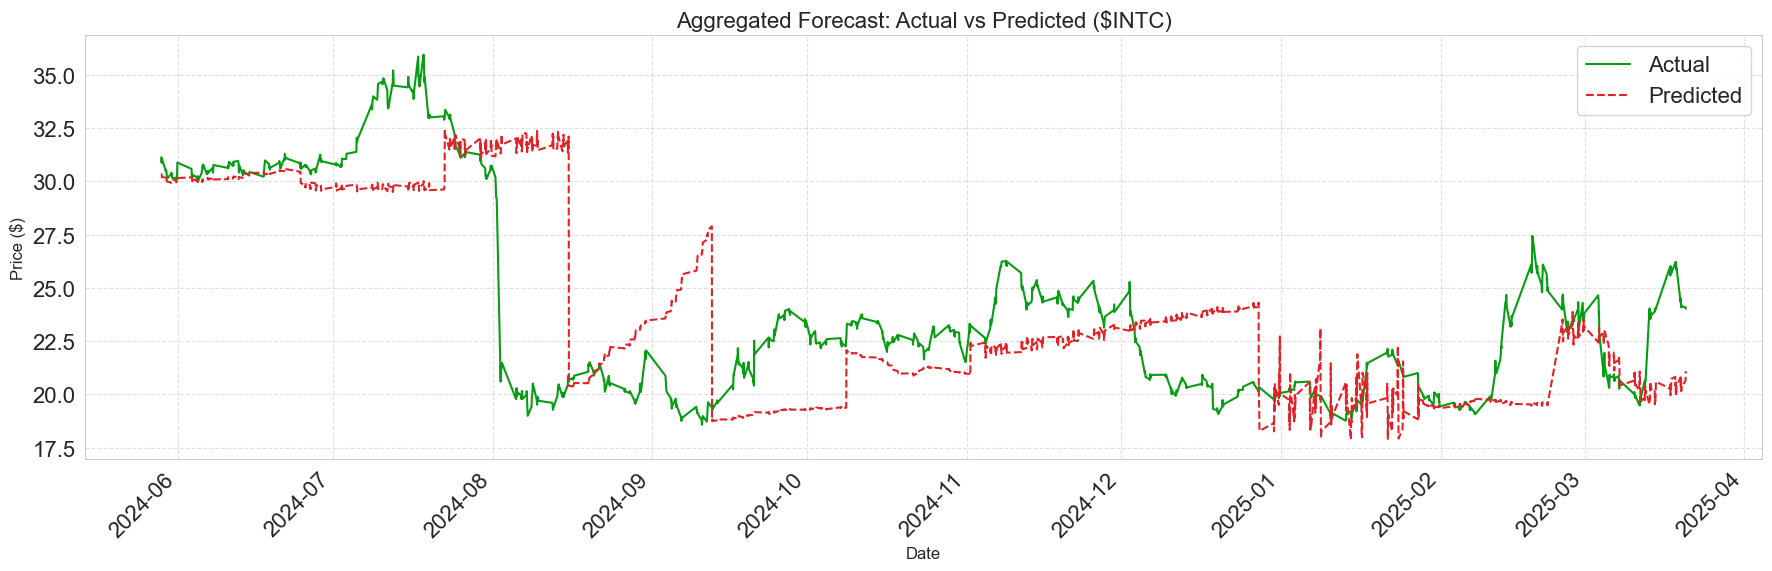

In [216]:
import matplotlib.pyplot as plt
import pandas as pd

# Configuration
context_window = 2048
forecast_horizon = 128
max_start = len(input_df) - context_window - forecast_horizon
backtest_starts = list(range(0, max_start + 1, forecast_horizon))

# Store forecasts and actuals
all_forecasts = []
all_actuals = []

# Loop through windows and plot each individually
for idx, start_idx in enumerate(backtest_starts):
    # Get context data
    context_end = start_idx + context_window
    context_data = input_df.iloc[start_idx:context_end]
    
    # Generate forecast
    forecast_df = tfm.forecast_on_df(
        context_data,
        freq="H",
        value_name="y",
        num_jobs=-1
    )[:forecast_horizon]

    # Align with actual data
    actual_start = context_end
    actual_end = actual_start + forecast_horizon
    actual_data = input_df.iloc[actual_start:actual_end]
    forecast_df["ds"] = actual_data["ds"].values

    # Plot individual window
    plt.figure(figsize=(18, 4))
    plt.plot(actual_data["ds"], actual_data["y"], 
             color="#069d12", linewidth=2, label="Actual")
    plt.plot(forecast_df["ds"], forecast_df["timesfm"], 
             color="#e32227", linestyle="--", linewidth=2, label="Predicted")
    
    plt.title(f"Window {idx+1} (Start: {context_data['ds'].iloc[0].date()} → Forecast: {actual_data['ds'].iloc[0].date()} to {actual_data['ds'].iloc[-1].date()}", 
              fontsize=12, pad=10)
    plt.xlabel("Date", fontsize=10)
    plt.ylabel("Price ($)", fontsize=10)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(frameon=True, fontsize=8)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Store for aggregated plot
    all_forecasts.append(forecast_df)
    all_actuals.append(actual_data)

# Combined plot (original code)
full_forecast = pd.concat(all_forecasts)
full_actual = pd.concat(all_actuals)

plt.figure(figsize=(18, 6))
plt.plot(full_actual["ds"], full_actual["y"], color="#069d12", label="Actual")
plt.plot(full_forecast["ds"], full_forecast["timesfm"], color="#e32227", linestyle="--", label="Predicted")
plt.title("Aggregated Forecast: Actual vs Predicted ($INTC)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

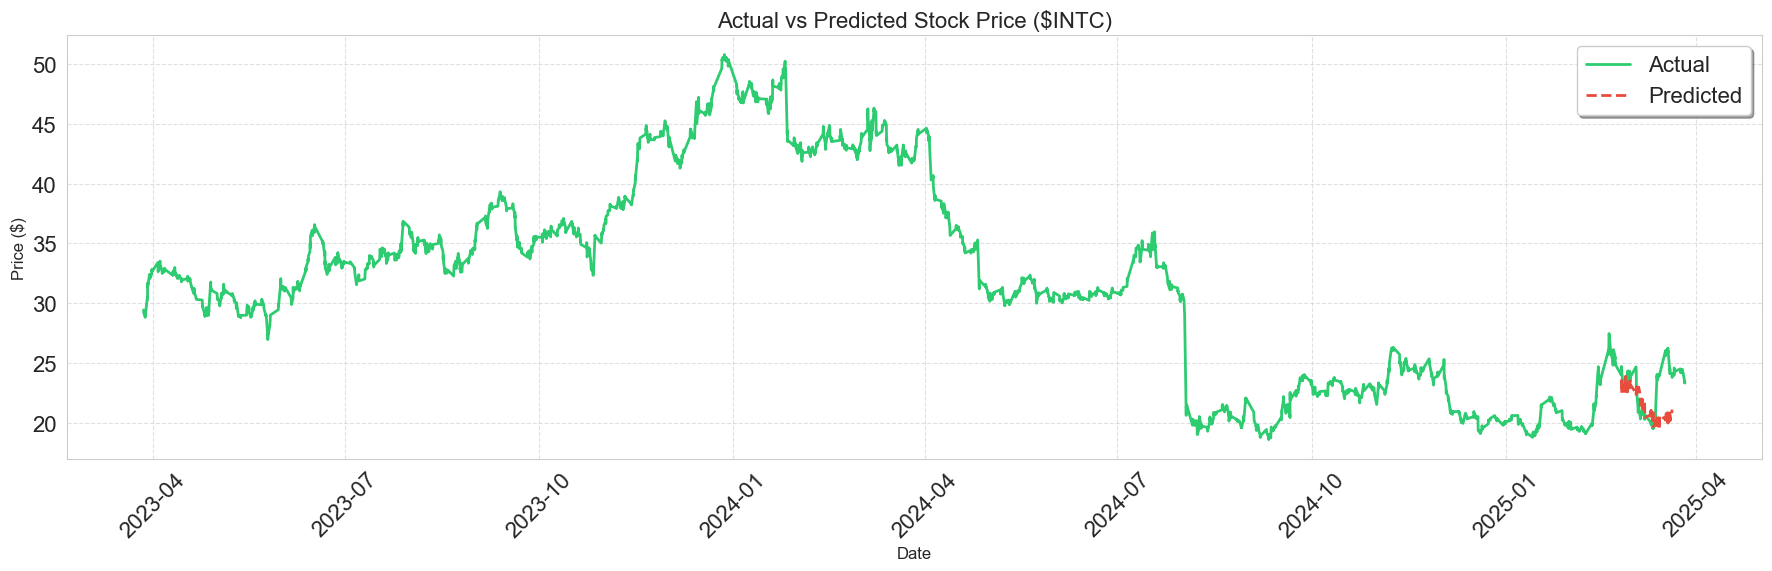

In [211]:
plt.figure(figsize=(18, 6))
plt.plot(input_df["ds"], input_df["y"], color='#2ecc71', linewidth=2, label="Actual")
plt.plot(forecast_df["ds"], forecast_df["timesfm"], color='#e74c3c', linestyle='--', linewidth=2, label="Predicted")
plt.title("Actual vs Predicted Stock Price ($INTC)", fontsize=16)
plt.ylabel("Price ($)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45)
plt.legend(frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Fi

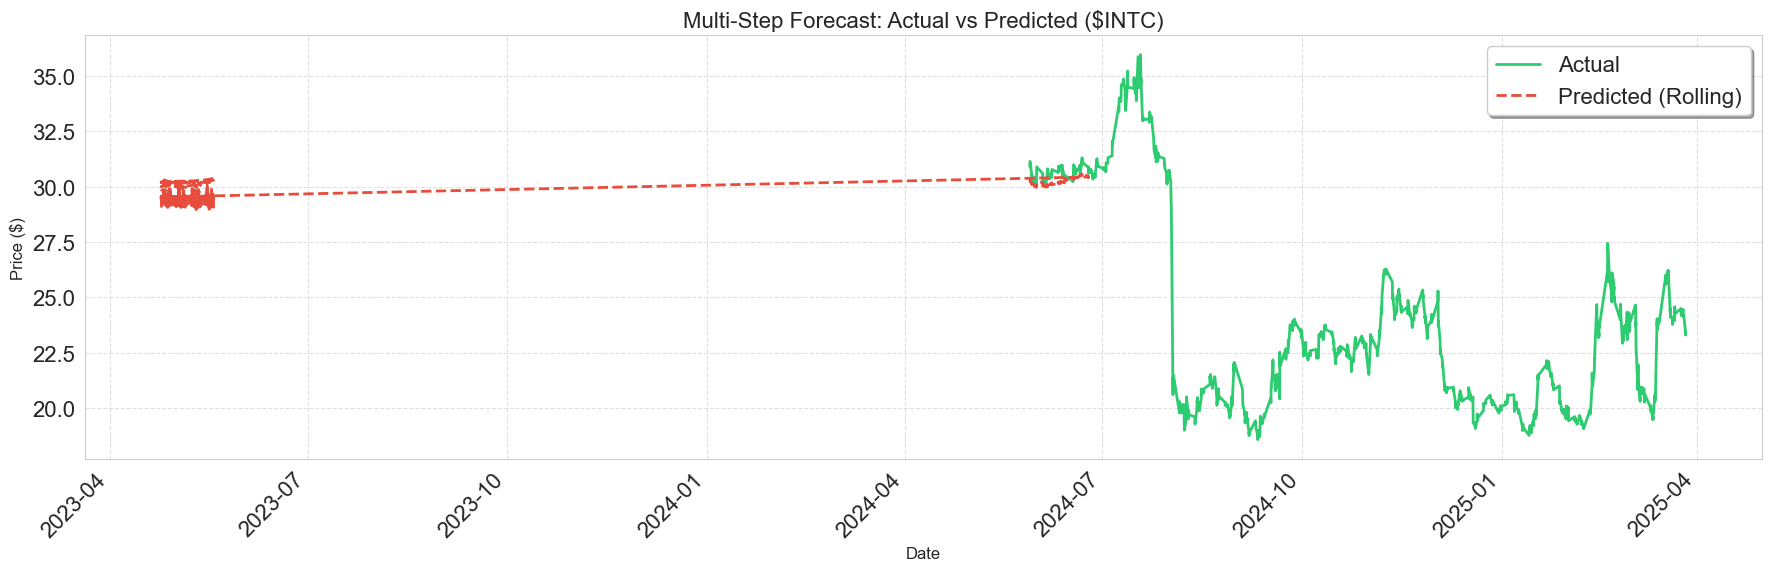